In [2]:
import datetime

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import figure
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn import linear_model
from sklearn import ensemble
from sklearn import svm
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import optuna
from optuna.samplers import TPESampler
import joblib
import os
from Config import * 
plt.rcParams['figure.figsize'] = [10, 5]  # size
plt.rcParams['figure.dpi'] = 100 # better quality of plots

In [4]:
class datapreparation:
    def __init__(self) -> None:
        pass
    
    def extraire_top_car_per_column_name(self,dataframe,columnName,n):
        """
        eliminer les marques qui ont un nombre de voiture inférieur à n dans la base de donnée actuelle
        exemple:
        n=20
        Je supprime toutes les lignes de la marque fiat car fiat a 19 voitures.
        De meme pour le modele 
        """
        category_counts = dataframe[columnName].value_counts().to_dict()
        column = list(category_counts.keys())
        filtered_category_counts = {column: count for column, count in category_counts.items() if count > n}
        column = list(filtered_category_counts.keys())
        dataexp=dataframe.loc[dataframe[columnName].isin(column),:]
        dataexp.drop(columns=["Unnamed: 0"],inplace=True) if "Unnamed: 0" in dataexp.columns else dataexp
        return dataexp
    
    def remove_outliers(self,group,min_value,max_value):
        """
        Supprimer les valeurs aberrantes par marque
        """
        lower_bound = group['Prix'].quantile(min_value)
        upper_bound = group['Prix'].quantile(max_value)
        return group[(group['Prix'] >= lower_bound) & (group['Prix'] <= upper_bound)]
    
    def Boxplot_figure(self,dataframe,ColumnName):
        """
        Boite à moustache pour la visualisation des valeurs aberrantes par marque 
        """
        plt.figure(figsize=(20,6))
        dataframe.boxplot(column=["Prix"],by=ColumnName)
        plt.ylabel('Valeurs')
        # plt.show()
        plt.xticks(rotation=90);


<Figure size 2000x600 with 0 Axes>

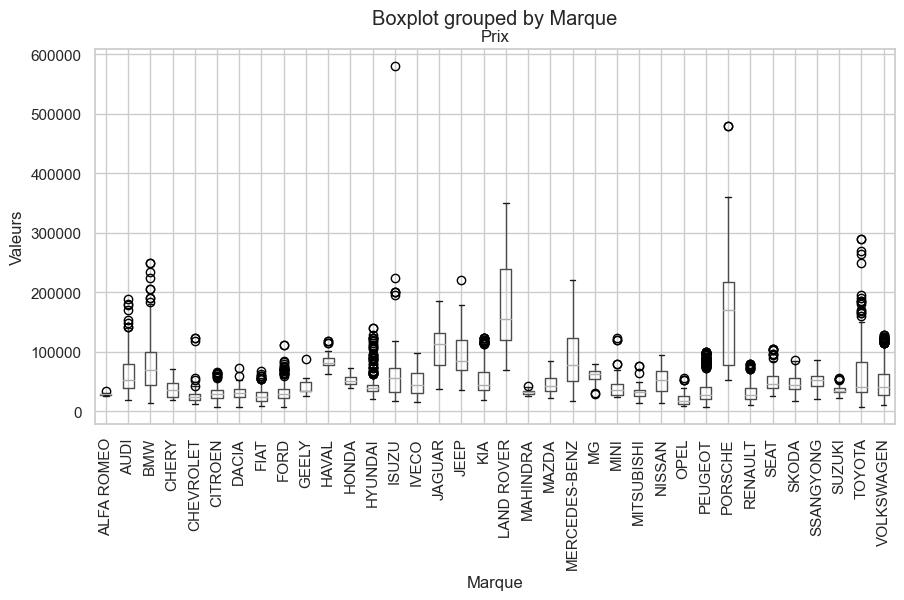

In [5]:
data=pd.read_sql('DataCleaned',con=engine)
prepare=datapreparation()
data = data.loc[data.Kilometrage != 0]
data = data.loc[data.Annee!=0]
data = data.loc[data.PuissanceFiscale!=0]
data = data.loc[data.Prix!=0]
data = data.loc[data.Energie!='INCONNU']
data = data.loc[data.BoiteVitesse!='INCONNU']
data= data.drop_duplicates()
data = prepare.extraire_top_car_per_column_name(data,"Marque",15)
data = prepare.extraire_top_car_per_column_name(data,"Modele",6)
df_cleaned = data.groupby('Marque').apply(prepare.remove_outliers,min_value=0.01,max_value=0.98).reset_index(drop=True) 
prepare.Boxplot_figure(df_cleaned,'Marque')

In [6]:
for col in df_cleaned.columns:
            if df_cleaned[col].dtype == 'object':  # Check if the column contains strings
                label_encoder = LabelEncoder()
                df_cleaned[col] = label_encoder.fit_transform(df_cleaned[col])
df_cleaned.drop(columns='id',inplace = True)

<AxesSubplot:>

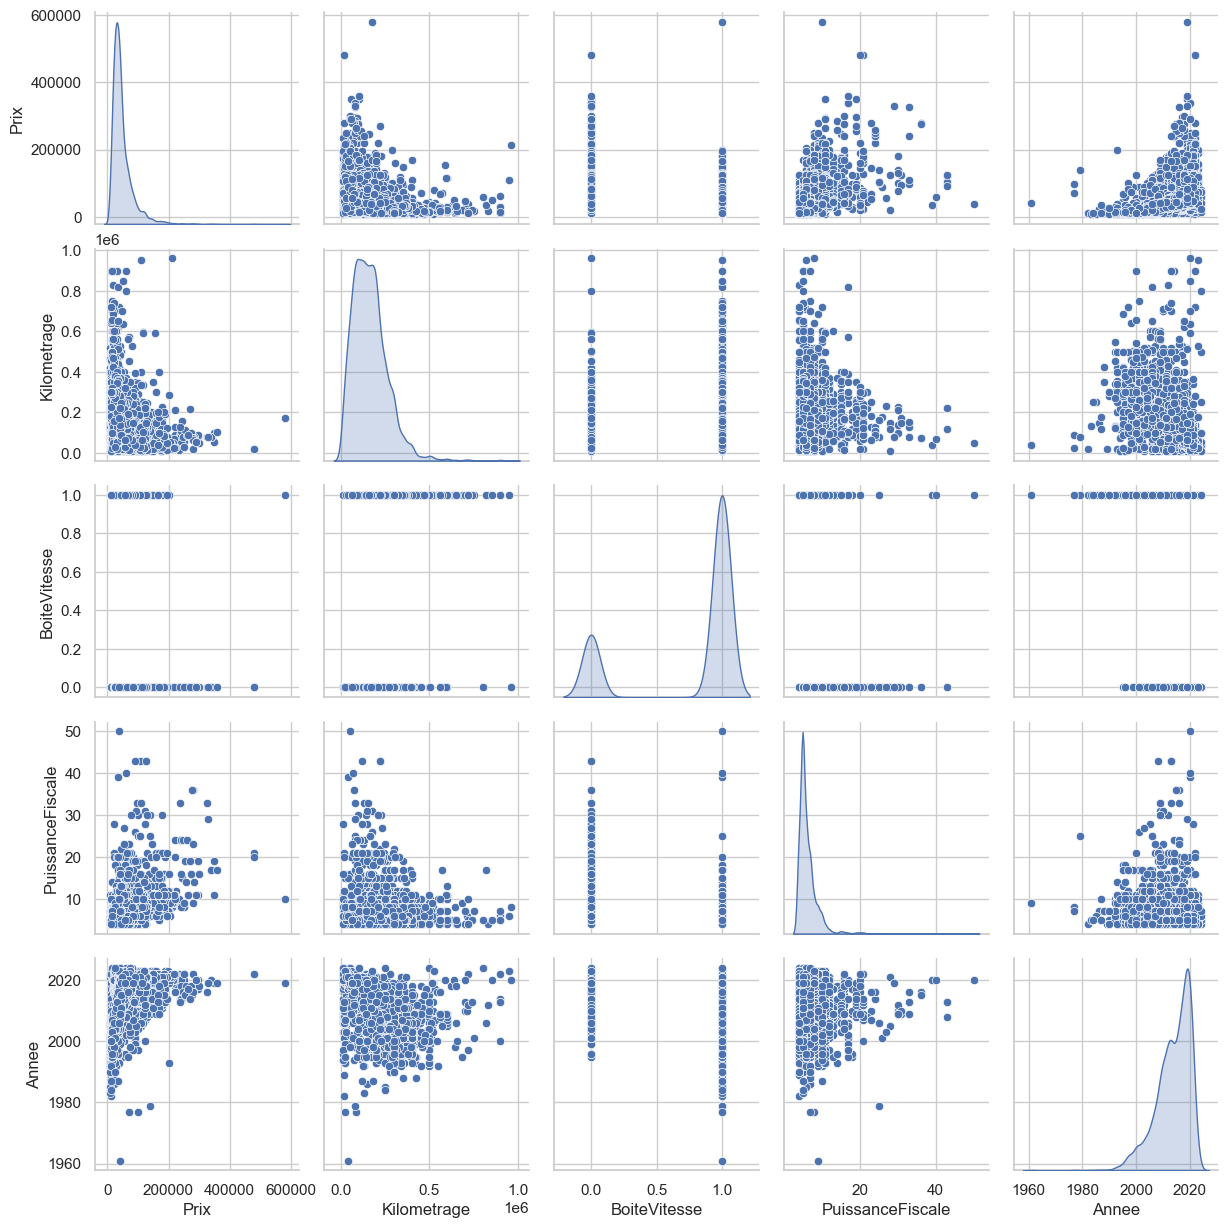

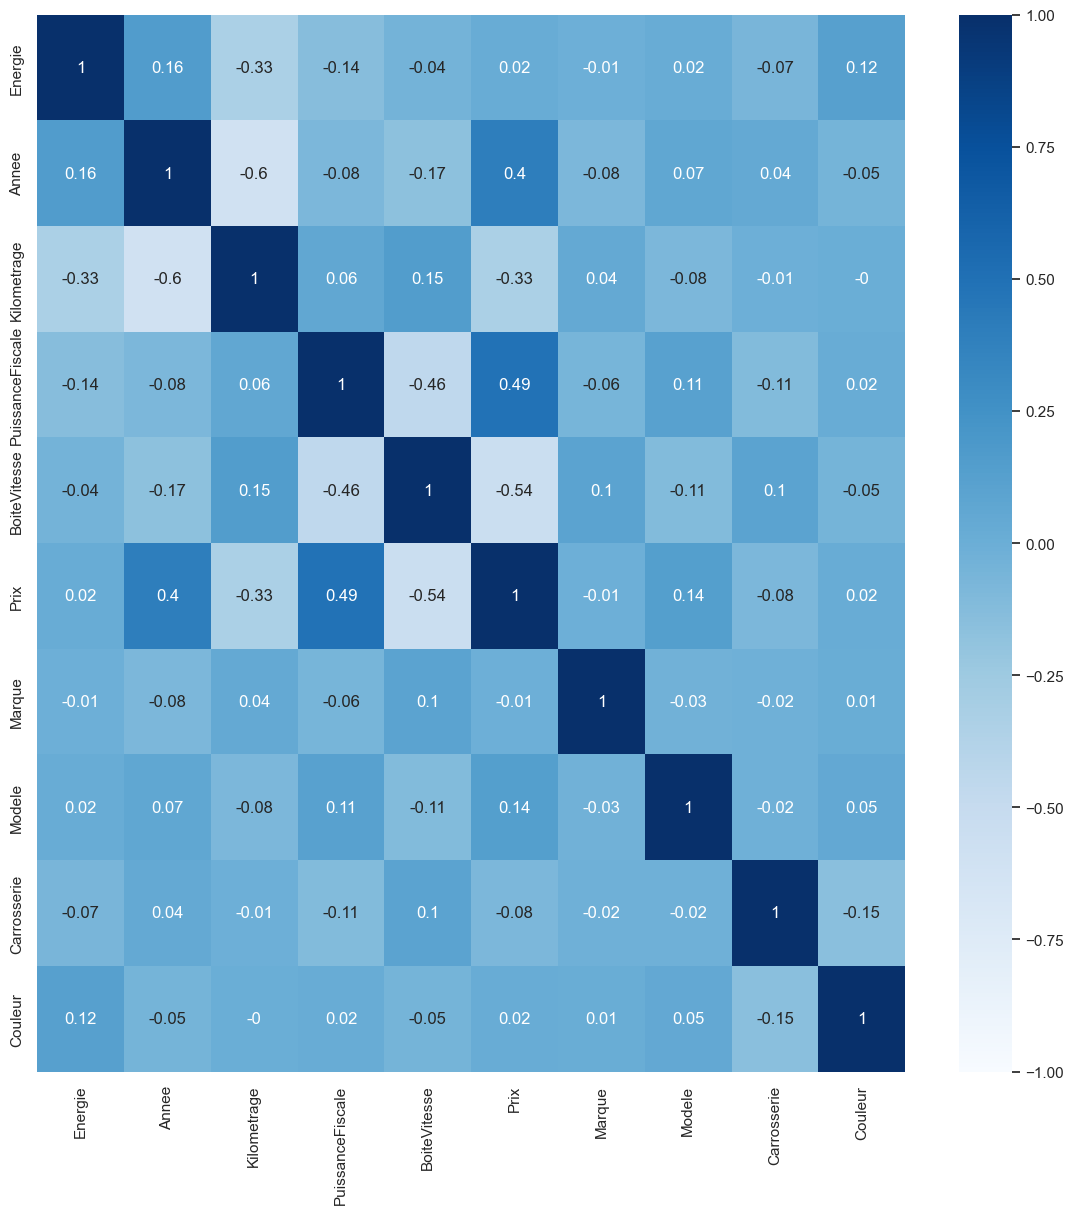

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
sns.pairplot(df_cleaned[["Prix","Kilometrage","BoiteVitesse","PuissanceFiscale","Annee"]], diag_kind='kde')
f = plt.figure(figsize=(14, 14))
sns.heatmap(df_cleaned.corr().round(2),cmap="Blues", annot=True,vmin=-1,vmax=1)


In [11]:
from sklearn.metrics import r2_score
class Prediction:
    def __init__(self) -> None:
        pass
 
    def label_encoder_columns(self,dataframe,ListOfcolumnsToDrop,targetColumnName):
        """
        Labeliser les données d'entrée avec LabelEncoder()
        """
        # Initialize LabelEncoder 
        output_values = dataframe[targetColumnName]
        input_values = dataframe.drop(columns=ListOfcolumnsToDrop)
        dict={}
        # Apply label encoding to each column
        for col in input_values.columns:
            if input_values[col].dtype == 'object':  # Check if the column contains strings
                label_encoder = LabelEncoder()
                input_values[col] = label_encoder.fit_transform(input_values[col])
                dict[col]=label_encoder
                # joblib.dump(label_encoder, 'C:\\Users\\Mousser\\Desktop\\ScrappingSites\\PhaseMachineLearning\\label_encoder'+ col + '.pkl')
        return input_values, output_values,dict
    
    def train_test_split(self,input_values, output_values):
        X_train, X_test, y_train, y_test = train_test_split(input_values, output_values, test_size=0.2, random_state=42)
        return X_train, X_test, y_train, y_test
    
    def predict_algo(self,X_train,y_train,X_test,y_test,regressor):
        regressor.fit(X_train, y_train)
        # Make predictions on the testing data
        y_pred = regressor.predict(X_test)
        # Calculate mean squared error
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        # print("Mean Squared Error:", mse)
        X_test["Target"] = y_test
        X_test["Prediction"] = y_pred
        X_test["AbsError"]=np.abs(y_test-y_pred)
        mae = np.mean(X_test["AbsError"])
        # print("Mean Absolute Error:", mae)
        return X_test,mse,mae, regressor,r2

In [18]:
df = pd.read_sql('DataCleaned',con=engine)
df = df.loc[df['Kilometrage'] != 0]
df = df.loc[df.Annee!=0]
df = df.loc[df.PuissanceFiscale!=0]
df = df.loc[df.Prix!=0]
df = df.loc[(df.Modele!="GOLF")&(df.Modele!="POLO")&(df.Modele!="CLIO")]
df = df.loc[df['Annee']!=datetime.datetime.now().year]
df = df.drop(columns={'Couleur',"Carrosserie"})
df= df.drop_duplicates()
# &(df['Marque'] != "ISUZU" )
df=df.loc[(df['Marque'] != "PORSCHE" )
          &(df['Marque'] != "MINI" )
          &(df['Marque'] != "LAND ROVER") 
          &(df['Marque'] != "JAGUAR")
          &(df['Marque'] != "JEEP")]
print("taille de DB: ",len(df))
df['Kilometrage_par_Annee'] = (df['Kilometrage'] / (datetime.datetime.now().year - df['Annee'])).astype(int)
models=[linear_model.Lasso(),
        linear_model.LinearRegression(),
        svm.SVR(),
        linear_model.Ridge(),
        linear_model.ElasticNet(),
        ensemble.GradientBoostingRegressor(),
        ExtraTreeRegressor(),
        RandomForestRegressor(),#100, random_state=42
        DecisionTreeRegressor(),
        XGBRegressor()
        ]
mseList=[]
maeList=[]
r2List=[]
prepare=datapreparation()
df = prepare.extraire_top_car_per_column_name(df,"Marque",15)
df = prepare.extraire_top_car_per_column_name(df,"Modele",6)
df = df.groupby('Marque').apply(prepare.remove_outliers,min_value=0.01,max_value=0.98).reset_index(drop=True) 
print("taille de DB: ",len(df))
predict = Prediction()
scaler = MinMaxScaler()
# scaler = StandardScaler()
df['Prix_normalisé'] = scaler.fit_transform(df[['Prix']])
# plt.plot(data.Prix_normalisé)
inputValue,outputValue,dic= predict.label_encoder_columns(df,["Prix","Prix_normalisé"],"Prix_normalisé")
X_train, X_test, y_train, y_test = predict.train_test_split(inputValue,outputValue)
for model in models:
        print(model)
        regressor = model
        dfPrediction,mse,mae, trainedModel,r2=predict.predict_algo(X_train,y_train,X_test,y_test,regressor)
        mseList.append(mse)
        maeList.append(mae)
        r2List.append(r2)
        X_test.drop(columns=["Target","Prediction","AbsError"],inplace=True)
        

taille de DB:  8409
taille de DB:  7347
Lasso()
LinearRegression()


C:\Users\Mousser\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Mousser\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Mousser\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Mousser\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:

SVR()


C:\Users\Mousser\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  warnings.warn(


Ridge()


C:\Users\Mousser\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Mousser\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Mousser\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Mousser\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  war

ElasticNet()
GradientBoostingRegressor()


C:\Users\Mousser\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Mousser\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Mousser\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Mousser\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  war

ExtraTreeRegressor()
RandomForestRegressor()


C:\Users\Mousser\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Mousser\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  warnings.warn(


DecisionTreeRegressor()
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


C:\Users\Mousser\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [11]:
modl=["Lasso",
"LinearRegression",
"svm",
"Ridge",
"ElasticNet",
"GradientBoostingRegressor",
"ExtraTreeRegressor",
"RandomForestRegressor",
"DecisionTreeRegressor",
"XGBRegressor"]
# dicR2={}
# for index,model in enumerate (modl):
#     dicR2[model]= r2List[index]
# plt.scatter(modl,r2List)
# plt.xticks(rotation=90);
# print(dicR2)
dicMse={}
for index,model in enumerate (modl):
    dicMse[model]= mseList[index]
plt.scatter(modl,mseList)
plt.xticks(rotation=90);
print(dicMse)

NameError: name 'mseList' is not defined

NameError: name 'modl' is not defined

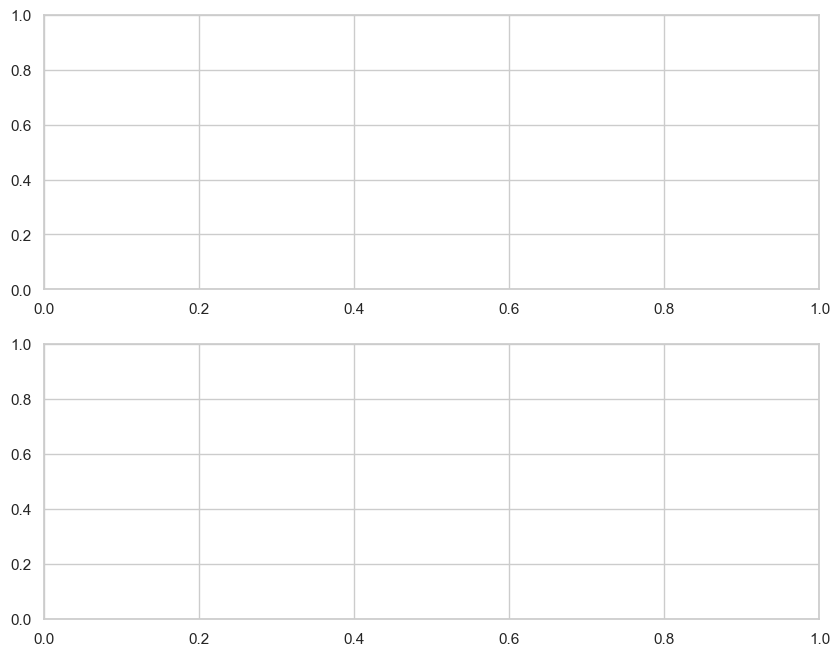

In [10]:
# Création de sous-graphiques
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Tracé du premier graphique (R2)
axs[0].scatter(modl, r2List)
axs[0].set_xticks(modl)
axs[0].set_xticklabels(modl, rotation=90)
axs[0].set_title('R2 Scores')
axs[0].set_ylabel('R2')

# Tracé du deuxième graphique (MSE)
axs[1].scatter(modl, mseList)
axs[1].set_xticks(modl)
axs[1].set_xticklabels(modl, rotation=90)
axs[1].set_title('Mean Squared Error (MSE)')
axs[1].set_ylabel('MSE')
axs[1].set_ylim(min(mseList) * 0.1, max(mseList) * 1.1)
axs[1].yaxis.set_major_locator(plt.MaxNLocator(10))  # Ajuste le nombre de graduations
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)  # Ajoute une grille
# Affichage des graphiques
plt.tight_layout()
plt.show()

In [14]:
prepare= datapreparation()
predict = Prediction()
def objective(trial):
    
    data = pd.read_sql('DataCleaned',con=engine)
    data = data.loc[data['Kilometrage'] != 0]
    data = data.loc[data.Annee!=0]
    data = data.loc[data.PuissanceFiscale!=0]
    data = data.loc[data.Prix!=0]
    data = data.drop(columns={'Couleur',"Carrosserie"})
    # data.drop(columns=["Unnamed: 0"],inplace=True)
    data = data.loc[data['Annee'] != datetime.datetime.now().year]
    data = data.loc[(data.Modele!="GOLF")&(data.Modele!="POLO")&(data.Modele!="CLIO")]
    #&(data['Marque'] != "ISUZU" )
    data=data.loc[(data['Marque'] != "PORSCHE" )
                  &(data['Marque'] != "MINI" )
                  & (data['Marque'] != "LAND ROVER") 
                  &(data['Marque'] != "JAGUAR")
                  &(data['Marque'] != "JEEP")]
    data= data.drop_duplicates()
    data['Kilometrage_par_Annee'] = (data['Kilometrage'] / (datetime.datetime.now().year - data['Annee'])).astype(int)
    data = prepare.extraire_top_car_per_column_name(data,"Marque",15)
    data = prepare.extraire_top_car_per_column_name(data,"Modele",6)
    data = data.groupby('Marque').apply(prepare.remove_outliers,min_value=0.01,max_value=0.98).reset_index(drop=True)
    scaler = MinMaxScaler()
    # scaler = StandardScaler()
    data['Prix_normalisé'] = scaler.fit_transform(data[['Prix']])
    inputValue,outputValue,d=predict.label_encoder_columns(data,["Prix","Prix_normalisé"],"Prix_normalisé")
    X_train, X_test, y_train, y_test = predict.train_test_split(inputValue,outputValue)

    param_grid = {
        # 'tweedie_variance_power': trial.suggest_discrete_uniform('tweedie_variance_power', 1.0, 2.0, 0.1),
        'max_depth': trial.suggest_int('max_depth', 5,5), # Extremely prone to overfitting!
        'n_estimators': trial.suggest_int('n_estimators', 450,600,1), # Extremely prone to overfitting!
        'eta': trial.suggest_float('eta', 0.0999,0.0999), # Most important parameter.
        # 'subsample': trial.suggest_discrete_uniform('subsample', 0.2, 0.9, 0.1),
        # # 'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.2, 0.9, 0.1),
        # 'colsample_bylevel': trial.suggest_discrete_uniform('colsample_bylevel', 0.2, 0.9, 0.1),
        # 'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-4, 1e4), # I've had trouble with LB score until tuning this.
        # 'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1e4), # L2 regularization
        # 'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1e4), # L1 regularization
        # 'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),
    } 
    
    reg = XGBRegressor(
        **param_grid,
        verbose=False
    )
    
    reg.fit(X_train, y_train,
            eval_set=[(X_test, y_test)], eval_metric='rmse',
        verbose=False)
    y_pred = reg.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    # Returns the best RMSE for the trial.
    return mse

In [ ]:
study = optuna.create_study(direction='minimize', sampler=TPESampler(), study_name='XGBRegressor')
study.optimize(objective,n_trials=2000)
print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('\tValue: {}'.format(trial.value))
print('\tParams: ')
for key, value in trial.params.items():
    print('\t\t{}: {}'.format(key, value))

In [ ]:
# optuna.visualization.plot_optimization_history(study)

In [ ]:
# optuna.visualization.plot_slice(study)

In [ ]:
# optuna.visualization.plot_contour(study)

In [38]:
data = pd.read_sql('DataCleaned',con=engine)
data.drop(columns='id')
print("taille de dataset brute: ",len(data))
data = data.loc[data['Kilometrage'] != 0]
data = data.loc[data.Annee!=0]
data = data.loc[data.PuissanceFiscale!=0]
data = data.loc[data.Prix!=0]
data = data.loc[(data.Modele!="GOLF")&(data.Modele!="POLO")&(data.Modele!="CLIO")]
data = data.loc[data['Annee']!=datetime.datetime.now().year]
data = data.drop(columns={'Couleur','Carrosserie'})
data= data.drop_duplicates()
# &(data['Marque'] != "ISUZU" )
# &(data['Marque'] != "AC")
data=data.loc[(data['Marque'] != "PORSCHE" )
              &(data['Marque'] != "MINI" )
              & (data['Marque'] != "LAND ROVER")
              &(data['Marque'] != "JAGUAR")
              &(data['Marque'] != "JEEP")]
data['Kilometrage_par_Annee'] = (data['Kilometrage'] / (datetime.datetime.now().year - data['Annee'])).astype(int)
regressor = XGBRegressor( 
 max_depth= 5,
 n_estimators= 700,
 eta=  0.09999
)
prepare=datapreparation()
data = prepare.extraire_top_car_per_column_name(data,"Marque",15)
data = prepare.extraire_top_car_per_column_name(data,"Modele",6)
data = data.groupby('Marque').apply(prepare.remove_outliers,min_value=0.01,max_value=0.98).reset_index(drop=True) 
predict = Prediction()
scaler = MinMaxScaler()
# scaler = StandardScaler()
print("taille de dataset apres la sélection des caractéristiques: ",len(data))
data['Prix_normalisé'] = scaler.fit_transform(data[['Prix']])
# joblib.dump(scaler, 'D:\\PredictCarsPrice\\ML\\RequirementsFiles\\scaler.joblib')
listOfColumnToDrop=["Prix","Prix_normalisé"]
targetColumnName="Prix_normalisé"
inputValue,outputValue,dict =predict.label_encoder_columns(data,listOfColumnToDrop,targetColumnName)
# for key , value in dict.items():
#   joblib.dump(value, 'D:\\PredictCarsPrice\\ML\\RequirementsFiles\\label_encoder'+ key + '.pkl')
X_train, X_test, y_train, y_test = predict.train_test_split(inputValue,outputValue)
predictedDf,mse,mae, trainedModel,r2 = predict.predict_algo(X_train,y_train,X_test,y_test,regressor)

print('mean squarred error MSE: ', mse)
print('mean absolute error MAE:',mae)
print('R2 Score: ',r2)

taille de dataset brute:  9958
taille de dataset apres la sélection des caractéristiques:  7347


C:\Users\Mousser\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Mousser\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(


mean squarred error MSE:  0.00035604912897901567
mean absolute error MAE: 0.01091167335409547
R2 Score:  0.8666312203077063


In [19]:
pred=predictedDf.Prediction.to_numpy()
pred=pred.reshape(-1,1)
pred_orig = scaler.inverse_transform(pred)

prix=predictedDf.Target.to_numpy()
prix=prix.reshape(-1,1)
prix_orig = scaler.inverse_transform(prix)

dictt={}
dictt["marque_orig"]=dict['Marque'].inverse_transform(predictedDf.Marque)
dictt["modele_orig"]=dict['Modele'].inverse_transform(predictedDf.Modele)
dictt["Energie_orig"]=dict['Energie'].inverse_transform(predictedDf.Energie)
# dictt["Couleur_orig"]=dict['Couleur'].inverse_transform(predictedDf.Couleur)
# dictt["Carrosserie_orig"]=dict['Carrosserie'].inverse_transform(predictedDf.Carrosserie)
dictt["Kilometrage"]=predictedDf["Kilometrage"]
dictt["Annee"]=predictedDf["Annee"]
dictt["Target"]=prix_orig.reshape(-1)
dictt["Prediction"]=pred_orig.reshape(-1)
dictt["mae"]=np.abs(dictt["Prediction"]-dictt["Target"])
dictt["maePerc"]=100 * dictt["mae"] / dictt["Target"]
datapredictorg = pd.DataFrame(dictt)
datapredictorg

,marque_orig,modele_orig,Energie_orig,Kilometrage,Annee,Target,Prediction,mae,maePerc
6443,TOYOTA,COROLLA,ESSENCE,250000,1993,10000.0,10507.049805,507.049805,5.070498
5553,RENAULT,SYMBOL,ESSENCE,108000,2010,26500.0,31246.955078,4746.955078,17.913038
457,BMW,SERIE3,DIESEL,230000,2014,65000.0,56221.003906,8778.996094,13.506148
5070,PEUGEOT,2008,ESSENCE,110000,2019,47500.0,46926.906250,573.093750,1.206513
2722,ISUZU,DMAX,DIESEL,86000,2017,112000.0,65242.605469,46757.394531,41.747674
...,...,...,...,...,...,...,...,...,...
705,CHEVROLET,AVEO,ESSENCE,121000,2014,25000.0,25365.701172,365.701172,1.462805
7031,VOLKSWAGEN,GOLF8,ESSENCE,25000,2020,99900.0,95976.265625,3923.734375,3.927662
5862,SEAT,IBIZA,ESSENCE,140000,2018,42600.0,38105.785156,4494.214844,10.549800
4274,NISSAN,QASHQAI,ESSENCE,108000,2016,61000.0,60738.093750,261.906250,0.429355


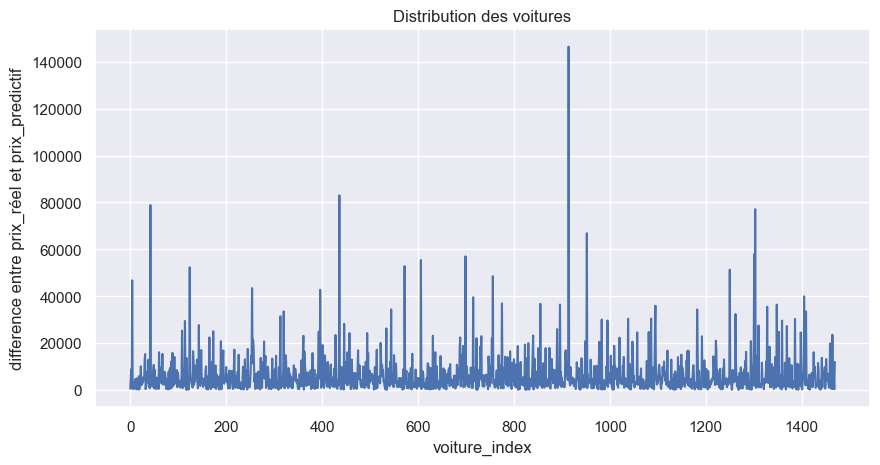

In [20]:
plt.plot(np.abs(prix_orig - pred_orig))
plt.title('Distribution des voitures')
plt.xlabel('voiture_index')
plt.ylabel('difference entre prix_réel et prix_predictif')
plt.grid(True)

In [23]:
mmae = np.mean(np.abs(prix_orig - pred_orig))
print('la moyenne des mae:',mmae)

la moyenne des mse: 6252.388839617878


In [25]:
std_mae = np.std(np.abs(prix_orig - pred_orig))
print("L'écart type des mae:",std_mae)

L'écart type des mae: 8820.93464973517


In [26]:
median = np.median(np.abs(prix_orig - pred_orig))
print("La mediane des mae:",median)

La mediane des mae: 3796.619140625


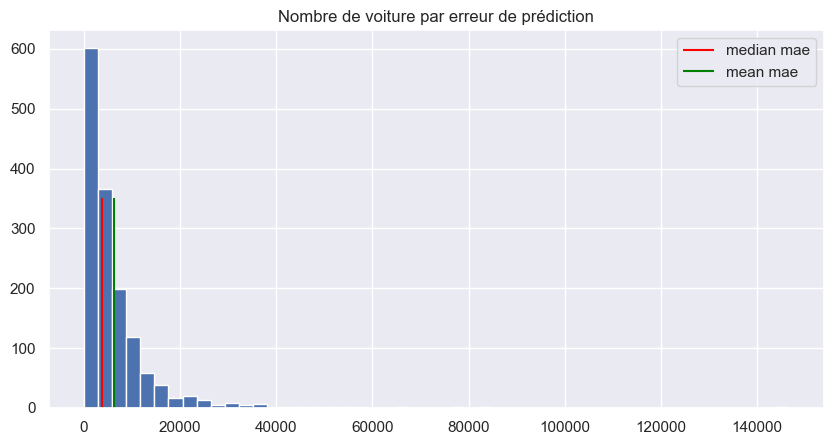

In [29]:
plt.hist(np.abs(prix_orig - pred_orig), bins=50)
plt.vlines(np.median(np.abs(prix_orig - pred_orig)), 0, 350, label="median mae", colors="red")
plt.vlines(np.mean(np.abs(prix_orig - pred_orig)), 0, 350, label="mean mae", colors="green")
plt.title('Nombre de voiture par erreur de prédiction')
plt.grid(True)
plt.legend();

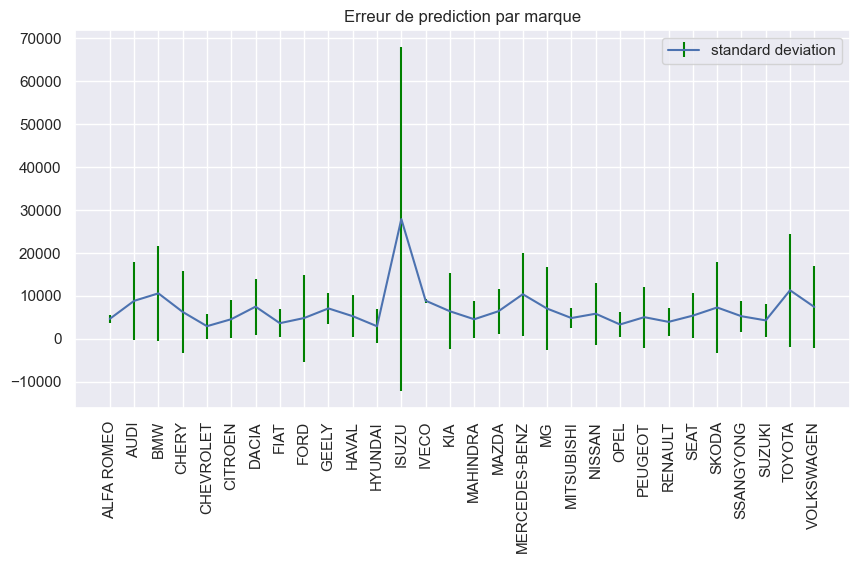

In [30]:
#Mean mean absolute error
mean_mae_by_marque = datapredictorg.groupby("marque_orig").apply(lambda x: np.mean(x['mae']))
mean_mae_by_marque
#Standard deviation mean absolute error 
std_mae_by_marque = datapredictorg.groupby("marque_orig").apply(lambda x: np.std(x['mae']))
x = mean_mae_by_marque.index
y =  mean_mae_by_marque.values
fig = plt.figure()
plt.errorbar(x, y, yerr=std_mae_by_marque.values, label='standard deviation',ecolor='green')
plt.xticks(rotation=90);
plt.title('Erreur de prediction par marque')
plt.grid(True)
plt.legend();